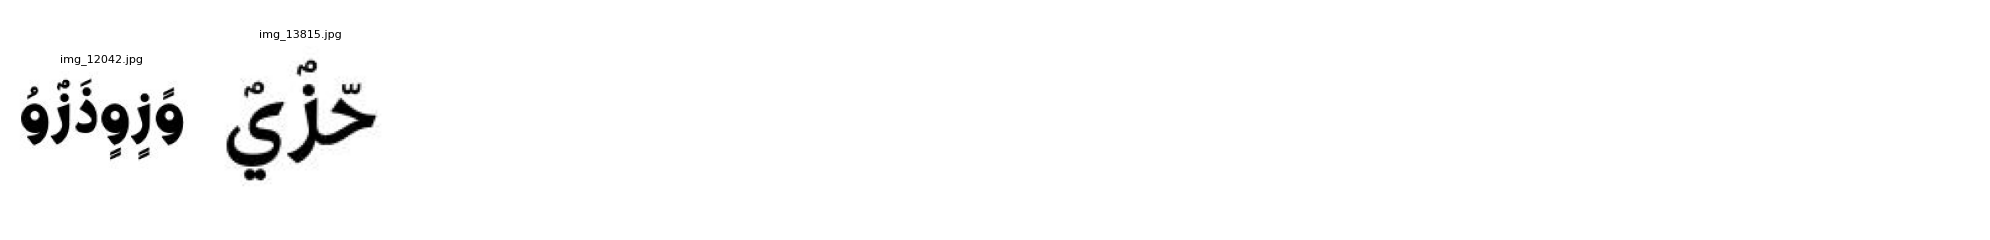

In [1]:
import os
import matplotlib.pyplot as plt
import cv2

# Dossier contenant les images
input_dir = 'aa/train/images'  # ⬅️ Remplace par le chemin de ton dossier

# Récupérer tous les fichiers image du dossier (png, jpg, jpeg, bmp, tif, tiff)
extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(extensions)]

# Ne garder que les images de l'index 200 à 299 (100 images)
image_files = image_files[:2]

# Déterminer la taille de la grille d'affichage
cols = 10  # 10 images par ligne
rows = (len(image_files) + cols - 1) // cols

# Créer la figure
fig, axes = plt.subplots(rows, cols, figsize=(20, 2.5 * rows))
axes = axes.flatten()

# Afficher les images
for i, filename in enumerate(image_files):
    image_path = os.path.join(input_dir, filename)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Erreur de lecture : {filename}")
        continue
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axes[i].imshow(image)
    axes[i].set_title(filename, fontsize=8)
    axes[i].axis('off') 

# Supprimer les sous-graphiques non utilisés
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


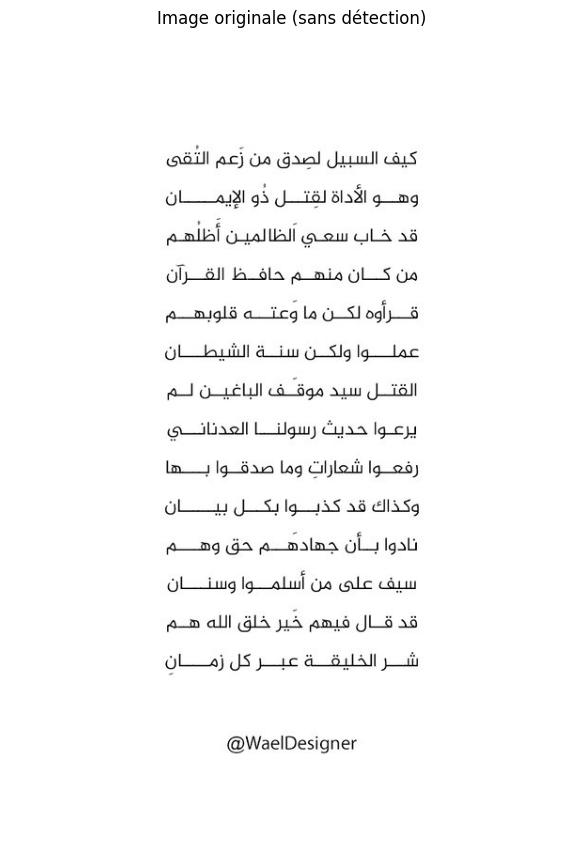

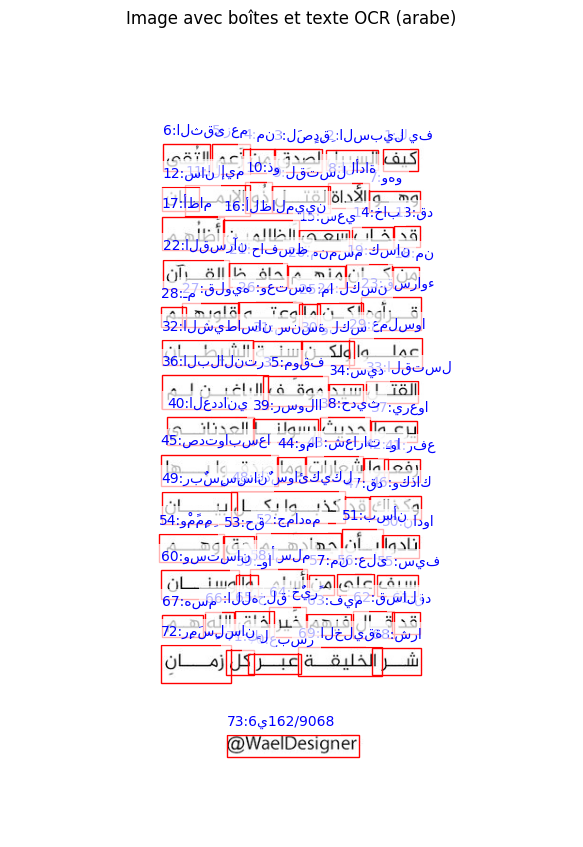

Texte organisé (de droite à gauche, ligne par ligne):
Ligne 1: كيف السبيل لَصٍدِقِ من زعم الثقى
Ligne 2: وهو الأداة لقتسل ذو الإيم سان
Ligne 3: قد خاب سعي ألظالميين أظام
Ligne 4: من كسان منمسم حافسظ القسرآن
Ligne 5: قسراوء لكسن ما وعتسه قلويه ـم
Ligne 6: عملسوا ولكس سنسة الشيطاسان
Ligne 7: القتسل سيد موقف البلالنتر
Ligne 8: يرعوا حديث رسولاا العدداني
Ligne 9: رفع ـوا شعارات وما صدتوابسعا
Ligne 10: وكذاك قد كذسوائكيكل ربٌسٍسِسانٌ
Ligne 11: نادوا بسأن جمادهم حق وْمًمِمِ
Ligne 12: سيف على من أسلم ـوا وستسان
Ligne 13: قد قسال فيم خٌيِرً خلق الله هسم
Ligne 14: شرا الخليقة عبسر كل رِمَسٍلسانٍ
Ligne 15: 6ي162/9068


In [2]:
import io
from doctr.io import DocumentFile
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from doctr.models.detection.differentiable_binarization.pytorch import db_resnet50
from doctr.models.recognition import parseq
from doctr.models.zoo import ocr_predictor
import torch
from PIL import Image
from doctr.models import detection_predictor
from doctr.datasets.vocabs import VOCABS

# === Charger l'image ===
image_path = "image.png"
image = DocumentFile.from_images(image_path)[0]
image_np = np.array(image)

# === Charger les modèles ===
det_model = db_resnet50(pretrained=True, pretrained_backbone=True)
det_model.load_state_dict(torch.load("output/detectionn.pt", map_location="cpu"))

reco_model = parseq(pretrained=True, pretrained_backbone=True, vocab=VOCABS['arabic'])
reco_model.load_state_dict(torch.load("output/Rbest.pt", map_location="cpu"))

predictor = ocr_predictor(det_arch=det_model,reco_arch=reco_model,pretrained=True,assume_straight_pages=True,straighten_pages=True,export_as_straight_boxes=True,detect_orientation=True,disable_page_orientation=True,disable_crop_orientation=True)

prediction = predictor([image])
page = prediction.pages[0]

# === Extraction des mots ===
words = []
for block in page.blocks:
    for line in block.lines:
        for word in line.words:
            words.append({
                'geometry': getattr(word, 'geometry', ((0, 0), (0, 0))),
                'value': getattr(word, 'value', '')
            })

# === Filtrage des boîtes valides ===
min_width = 0.01
min_height = 0.02
filtered_words = []
for word in words:
    (x_min, y_min), (x_max, y_max) = word['geometry']
    width = x_max - x_min
    height = y_max - y_min
    if width > min_width and height > min_height:
        filtered_words.append(word)

# === Dimensions image ===
height_px, width_px = image_np.shape[:2]

# === Organiser les mots par ligne et par position horizontale ===
y_tolerance = 0.03  # tolérance verticale pour regrouper en lignes
lines = {}
for word in filtered_words:
    (x_min, y_min), (x_max, y_max) = word['geometry']
    y_center = (y_min + y_max) / 2

    found_line = False
    for y_key in lines.keys():
        if abs(y_center - y_key) < y_tolerance:
            lines[y_key].append(word)
            found_line = True
            break

    if not found_line:
        lines[y_center] = [word]

# Trier les lignes de haut en bas
sorted_lines = sorted(lines.items(), key=lambda x: x[0])

# Trier les mots dans chaque ligne de droite à gauche (arabe)
for y_center, line_words in sorted_lines:
    lines[y_center] = sorted(line_words, key=lambda w: -w['geometry'][1][0])

# === Affichage de l'image originale (sans boîtes) ===
plt.figure(figsize=(width_px / 100, height_px / 100))
plt.imshow(image_np)
plt.title("Image originale (sans détection)")
plt.axis("off")
plt.tight_layout()
plt.show()

# === Affichage : image avec boîtes ET texte OCR ===
fig, ax = plt.subplots(figsize=(width_px / 100, height_px / 100))
ax.imshow(image_np)
ax.set_title("Image avec boîtes et texte OCR (arabe)")

word_count = 1
for y_center, line_words in sorted_lines:
    for word in lines[y_center]:
        (x_min, y_min), (x_max, y_max) = word['geometry']
        width = x_max - x_min
        height = y_max - y_min
        if width < min_width or height < min_height:
            continue

        x_min_pixel = int(x_min * width_px)
        x_max_pixel = int(x_max * width_px)
        y_min_pixel = int(y_min * height_px)
        y_max_pixel = int(y_max * height_px)

        rect = patches.Rectangle(
            (x_min_pixel, y_min_pixel),
            x_max_pixel - x_min_pixel,
            y_max_pixel - y_min_pixel,
            linewidth=1,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

        ax.text(
            x_min_pixel,
            y_min_pixel - 10 if y_min_pixel > 10 else y_max_pixel + 10,
            f"{word_count}:{word['value']}",
            color='blue',
            fontsize=10,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )
        word_count += 1

ax.axis("off")

# Sauvegarder et afficher
plt.tight_layout()
plt.show()

# === Affichage texte dans la console ===
print("Texte organisé (de droite à gauche, ligne par ligne):")
for i, (y_center, line_words) in enumerate(sorted_lines):
    line_text = ' '.join([word['value'] for word in lines[y_center]])
    print(f"Ligne {i+1}: {line_text}")


In [ ]:
from doctr.models import recognition, login_to_hub, push_to_hf_hub
from doctr.datasets.vocabs import VOCABS
import torch
login_to_hub()

 # use the same vocab your model was trained on
reco_model = recognition.parseq(pretrained=True, pretrained_backbone=True, vocab=VOCABS['arabic'])
# Load your checkpoint
reco_params = torch.load('output/Rbest.pt', map_location="cpu")
reco_model.load_state_dict(reco_params)

push_to_hf_hub(
    reco_model,
    model_name='doctr-model-v1-arabic',
    task='recognition',
    arch='parseq',
    exist_ok=True
)


/home/chaima/ocr_arabic/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'get_token_permission' (from 'huggingface_hub.hf_api') is deprecated and will be removed from version '1.0'. Permissions are more complex than when `get_token_permission` was first introduced. OAuth and fine-grain tokens allows for more detailed permissions. If you need to know the permissions associated with a token, please use `whoami` and check the `'auth'` key.
  warnings.warn(warning_message, FutureWarning)
/home/chaima/ocr_arabic/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)


git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)


/home/chaima/ocr_arabic/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/home/chaima/.cache/huggingface/hub/doctr-model-v1-arabic is already a clone of https://huggingface.co/rania-sr/doctr-model-v1-arabic. Make sure you pull the latest changes with `repo.git_pull()`.
Pulling changes ...


Upload file pytorch_model.bin:   0%|          | 1.00/92.2M [00:00<?, ?B/s]

remote: -------------------------------------------------------------------------        
remote: Your push was accepted, but with warnings:         
remote: - Warning: empty or missing yaml metadata in repo card        
remote: help: https://huggingface.co/docs/hub/model-cards#model-card-metadata        
remote: -------------------------------------------------------------------------        
remote: -------------------------------------------------------------------------        
remote: Please find the documentation at:        
remote: https://huggingface.co/docs/hub/model-cards#model-card-metadata        
remote:         
remote: -------------------------------------------------------------------------        
To https://huggingface.co/rania-sr/doctr-model-v1-arabic
   f207133..d687243  main -> main

remote: Your push was accepted, but with warnings:         
remote: - Warning: empty or missing yaml metadata in repo card        
remote: help: https://huggingface.co/docs/hub/model-c

In [3]:
from doctr.models import detection_predictor, login_to_hub, push_to_hf_hub
from doctr.datasets.vocabs import VOCABS
from doctr.models.detection.differentiable_binarization.pytorch import db_resnet50

import torch
login_to_hub()

# use the same vocab your model was trained on
det_model = db_resnet50(pretrained=True, pretrained_backbone=True)
# Load your checkpoint
det_params = torch.load('output/detection.pt', map_location="cpu")
det_model.load_state_dict(det_params)  # Using det_params instead of reco_params

push_to_hf_hub(
    det_model,
    model_name='doctr-Detection-model-v1-arabic',
    task='detection',
    arch='db_resnet50',
    exist_ok=True
)

/home/chaima/ocr_arabic/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'get_token_permission' (from 'huggingface_hub.hf_api') is deprecated and will be removed from version '1.0'. Permissions are more complex than when `get_token_permission` was first introduced. OAuth and fine-grain tokens allows for more detailed permissions. If you need to know the permissions associated with a token, please use `whoami` and check the `'auth'` key.
  warnings.warn(warning_message, FutureWarning)
/home/chaima/ocr_arabic/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in 'login': write_permission. Will not be supported from version '1.0'.

Fine-grained tokens added complexity to the permissions, making it irrelevant to check if a token has 'write' access.
  warnings.warn(message, FutureWarning)


git-lfs/3.0.2 (GitHub; linux amd64; go 1.18.1)


/home/chaima/ocr_arabic/venv/lib/python3.10/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
Cloning https://huggingface.co/rania-sr/doctr-Detection-model-v1-arabic into local empty directory.
Pulling changes ...


Upload file pytorch_model.bin:   0%|          | 1.00/97.3M [00:00<?, ?B/s]

remote: -------------------------------------------------------------------------        
remote: Your push was accepted, but with warnings:         
remote: - Warning: empty or missing yaml metadata in repo card        
remote: help: https://huggingface.co/docs/hub/model-cards#model-card-metadata        
remote: -------------------------------------------------------------------------        
remote: -------------------------------------------------------------------------        
remote: Please find the documentation at:        
remote: https://huggingface.co/docs/hub/model-cards#model-card-metadata        
remote:         
remote: -------------------------------------------------------------------------        
To https://huggingface.co/rania-sr/doctr-Detection-model-v1-arabic
   d4ef19b..fcfdca2  main -> main

remote: Your push was accepted, but with warnings:         
remote: - Warning: empty or missing yaml metadata in repo card        
remote: help: https://huggingface.co/docs/h